In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from timefusion import TimeFusion
import random
import torch
from torch import nn


In [2]:
# Create dataset of two correlated, random walks on top of sine functions
# Set random seed to make result reproducible
np.random.seed(0)

# Random walk starts at 0,0
z = np.array([0,0])

# Covariance matrix for normal distribution
cov = [
    [1, 0.5],
    [0.5, 1]
]

# List to hold samples
samples = []

for i in range(30000):

    # Calculate underlying sine values
    y = 1*np.array([np.sin(0.04*i),np.sin((0.06*i + 1))])
    #y = 1*np.array([np.sin(0.04*i),np.sin(0.04*i)])

    # Draw random samples from normal distribution
    #z = np.random.multivariate_normal(z,cov)
    z = np.array([0,0])

    # Store samples
    samples.append(y + z)

# Create pandas DataFrame out of data
data = pd.DataFrame(data=samples,columns=["sine1","sine2"])

# Remove 50% of samples to make into an irregular time-series
keep = 1 # What fraction of cells to keep
mask = [False]*int(2*len(data)*keep) + [True]*int(2*len(data)*(1-keep))
random.shuffle(mask)
mask = np.array(mask).reshape((len(data),2))
data = data.mask(mask)

# Remove all rows without any data
data = data.dropna(axis = 0, how = 'all')


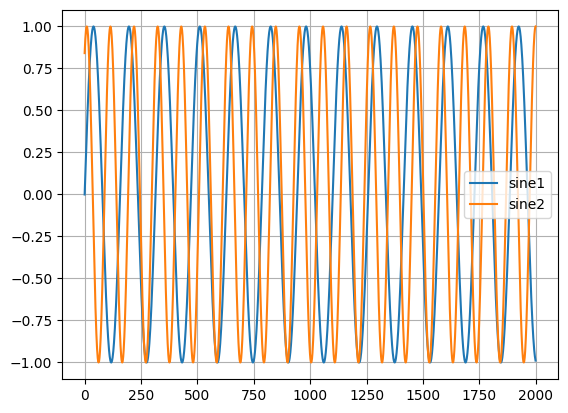

In [3]:
# Plot data so we can inspect it
data[:2000].plot()
plt.grid(True)

In [4]:
predictor = TimeFusion(
    datapoint_dim = 3,
    time_series_dim=2,
    context_length = 30,
    prediction_length = 10,
    device = torch.device("mps"),
    diff_steps=100,
    dim_feedforward=128,
    num_decoder_layers=2,
    num_encoder_layers=2,
    nhead=1,
    d_model=128,
)

In [5]:
print("Number of trainable parameters:",sum(p.numel() for p in predictor.parameters()))

Number of trainable parameters: 1289364


In [6]:
predictor.train(
    train_data=data[data.index <= 6000],
    epochs=60,
    val_data=data[data.index > 29000],
    val_metrics= {
        "Val MAE": nn.L1Loss(),
        "Val MSE": nn.MSELoss()
    },
    optimizer=torch.optim.Adam(params=predictor.parameters(),lr=1e-4)
)

 |==============================|  Batch: 94 / 94, Epoch: 1 / 60, Average Loss: 0.7425, Val MAE: 0.4655, Val MSE: 0.4052


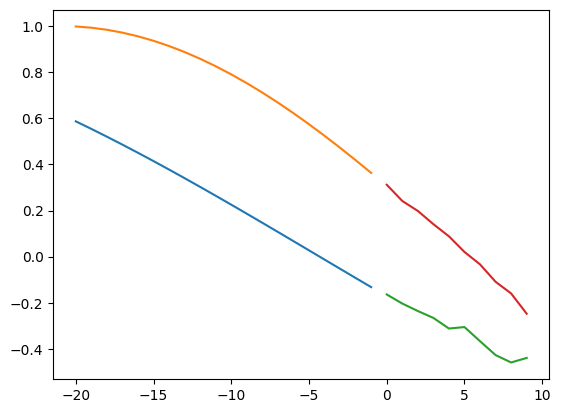

In [26]:
sample_index = 26000

samples = predictor.sample(
    data=data[data.index <= sample_index],
    num_samples=1,
    batch_size=32
)

plt.plot(data[data.index <= sample_index].index[-20:] - data.index[sample_index] - 1,list(data[data.index <= sample_index][-20:]['sine1']))
plt.plot(data[data.index <= sample_index].index[-20:] - data.index[sample_index] - 1,list(data[data.index <= sample_index][-20:]['sine2']))
# plt.plot(samples[0,0].cpu())
# plt.plot(samples[0,1].cpu())
plt.plot(torch.mean(samples.cpu(),axis=0)[0])
plt.plot(torch.mean(samples.cpu(),axis=0)[1])
#plt.plot(samples[0,1].cpu())